# Visualization of the graph in the embeddings' space

In [1]:
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph
import tensorflow as tf
import networkx as nx
import pandas as pd
import seaborn as sns
import scipy

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#graph_path = '../data/graph/email_eu/email_eu_edgelist.txt'
graph_path = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'

graph = read_graph(weighted=False, 
                   graph=graph_path,
                   directed=False)

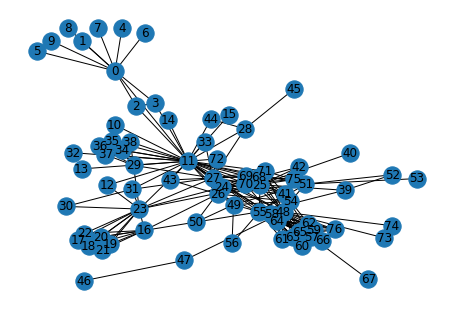

In [3]:
nx.draw(graph, with_labels = True)
plt.show()

In [7]:
%%time
tf.reset_default_graph()
with tf.Session() as sess:
    emb = n2i_nx_graph(nx_graph=graph, topics=2, use_tf=True, seed=10, translate=False, reduce=False, 
                       window_size=10,
                       walk_length=100,
                       num_walks=30,
                       dimensions=2,
                       p=1,
                       q=1,
                      beta=10)

mu:  (2,) log_std:  (2,)
CPU times: user 20.7 s, sys: 5.51 s, total: 26.2 s
Wall time: 11.9 s


In [8]:
nodes = [_ for _ in range(len(emb))]
x = [emb[_, 0] for _ in range(len(emb))]
y = [emb[_, 1] for _ in range(len(emb))]

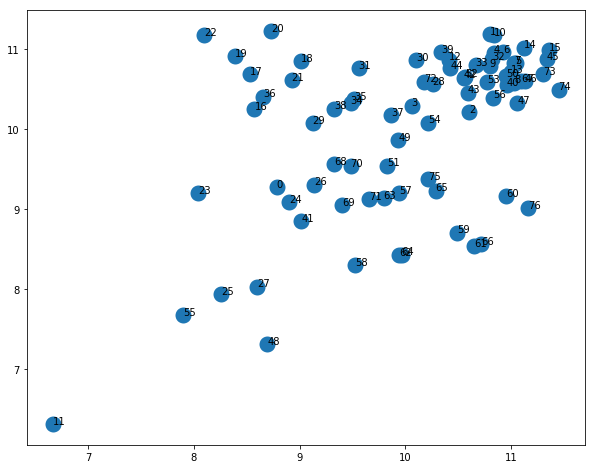

In [9]:
fig, ax = plt.subplots()
ax.scatter(x, y, linewidths=10)
for _ in range(len(nodes)):
    ax.annotate(nodes[_], (x[_], y[_]))
fig.set_size_inches(10, 8)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
params_list = [(100, 0.01), (10, 0.1), (0.1, 10), (0.01, 100)] # list of p,q
fig.set_size_inches(20, 18)
i = 0

for row in ax:
    for col in row:
        emb = n2i_nx_graph(nx_graph=graph, topics=2, use_tf=True, seed=10, translate=False, reduce=True, 
                   window_size=10,
                   walk_length=100,
                   num_walks=30,
                   dimensions=128,
                   p=params_list[i][0],
                   q=params_list[i][1])
        nodes = [_ for _ in range(len(emb))]
        x = [emb[_, 0] for _ in range(len(emb))]
        y = [emb[_, 1] for _ in range(len(emb))]
        col.scatter(x, y, linewidths=10)
        col.title.set_text(str(params_list[i]))
        for _ in range(len(nodes)):
            col.annotate(nodes[_], (x[_], y[_]))
        i += 1

plt.show()

# Null generative model

In [ ]:
import numpy as np
cov = np.matrix([[1, 0],[0, 1]])
N = 100
nodes = [_ for _ in range(N)]

emb = np.array([np.random.multivariate_normal([0,0], cov) for _ in range(N)])
emb = emb + np.abs(np.min(emb))

In [ ]:
def create_graph(emb, c=1, k=4):
    G = nx.Graph()
    for _ in nodes:
        G.add_node(_)
    for i in nodes:
        for l in range(k):
            diff = 0
            r = np.random.rand()
            curr_nodes = [_ for _ in nodes if _ != i]
            j = np.random.choice(curr_nodes)
            comb = scipy.special.binom(N, 2)
            # homophily bias
            diff = np.linalg.norm( emb[i]-emb[j])
            if diff >= c:
                bias = 0
            else:
                bias = 1/diff
            prob = bias
            if r <= prob:
                G.add_edge(i, j)
    return G

In [ ]:
G= create_graph(emb)
nx.draw(G, with_labels = True)
plt.show()

In [ ]:
Gcc = max(nx.connected_component_subgraphs(G), key=len)

In [ ]:
len(Gcc)

In [ ]:
x = [emb[_, 0] for _ in range(len(emb))]
y = [emb[_, 1] for _ in range(len(emb))]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y, linewidths=10)
for _ in range(len(nodes)):
    ax.annotate(nodes[_], (x[_], y[_]))
fig.set_size_inches(10, 8)

## grid search parameters

In [ ]:
from matplotlib.pyplot import figure
fig  = figure(num=None, figsize=(18, 16))
var = [0.01, 1, 10, 100]
covs  = [0.01, 1, 10, 100]
j = 1

for m in var:
    for c in covs:
        cov = np.matrix([[m, c],[c, m]])
        emb = np.array([np.random.multivariate_normal([0,0], cov) for _ in range(N)])
        emb = emb + np.abs(np.min(emb))
        G = create_graph(emb, 10)
        
        # Giant comp
        Gcc = len(max(nx.connected_component_subgraphs(G), key=len))
        
        ax = fig.add_subplot(4, 4, j)
        ax.title.set_text('va: '+str(m)+'; co: '+str(c) +' Gcc: '+str(Gcc))
        nx.draw(G, with_labels = True)
        j += 1

## size of gcc experiments

In [ ]:
N = 100
nodes = [_ for _ in range(N)]
k = 10

var = [1, 10, 30, 50, 70, 90, 110]
covs = [1, 10, 30, 50, 70, 90, 110]



args_list = []
nr_experiments = 20

for v in var:
    for c in covs:
        for seed in range(nr_experiments):
            args = [v, c, seed]
            args_list.append(args)

In [ ]:
from scipy.spatial import distance

# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 1000)

In [ ]:
def run_experiment(*args):
    v, c, seed = args
    cov = np.matrix([[v, c],[c, v]])
    emb = np.array([np.random.multivariate_normal([0,0], cov) for _ in range(N)])
    emb = emb + np.abs(np.min(emb))
    G = create_graph(emb, k)
    # Giant comp
    Gcc = len(max(nx.connected_component_subgraphs(G), key=len))
    for i in G.nodes:
        G.node[i]['interests'] = emb[i]
    si = sim_in(G)
    so = sim_out(G, 500)
    return args + (Gcc, si/so)

In [ ]:
result = list(map(lambda x: run_experiment(*x), args_list))

In [ ]:
df = pd.DataFrame(result, columns=['v', 'c', 'seed', 'Gcc', 'h'])
df2 = df.groupby(['v', 'c'])['Gcc'].mean().unstack()
df3 = df.groupby(['v', 'c'])['h'].mean().unstack()

In [ ]:
fig = figure(num=None, figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(df2)
plt.title('Gcc size (mean of 20 realizations)')

ax = fig.add_subplot(1, 2, 2)
sns.heatmap(df3)
plt.title('Homophily (mean of 20 realizations)')

In [ ]:
sns.set()
ax = df2.plot(figsize=(15, 12))

In [ ]:
ax = df3.plot(figsize=(15, 12))

## null model with barabasi albert as base model

In [ ]:
def barabasi_albert_graph(n, m, seed=None):
    if m < 1 or  m >=n:
        raise nx.NetworkXError(\
              "Barabási-Albert network must have m>=1 and m<n, m=%d,n=%d"%(m,n))
    if seed is not None:
        random.seed(seed)

    # Add m initial nodes (m0 in barabasi-speak)
    G=nx.empty_graph(m)
    G.name="barabasi_albert_graph(%s,%s)"%(n,m)
    # Target nodes for new edges
    targets=list(range(m))
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes=[]
    # Start adding the other n-m nodes. The first node is m.
    source=m
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source]*m,targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source]*m)
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        targets = np.random.choice(repeated_nodes,m)
        source += 1
        print('targets: ', targets, 'repeated_nodes: ',repeated_nodes)
    return G

In [ ]:
G = barabasi_albert_graph(10, 2)

In [ ]:
nx.draw(G)